## Hello, you ;)
This is a notebook for testing project ideas and ugly EDA stuff

In [1]:
# !pip install geopandas
# !pip install mapclassify
import geopandas as gpd
import mapclassify
import shapely
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
listings = pd.read_csv("../inputs/listings.csv")

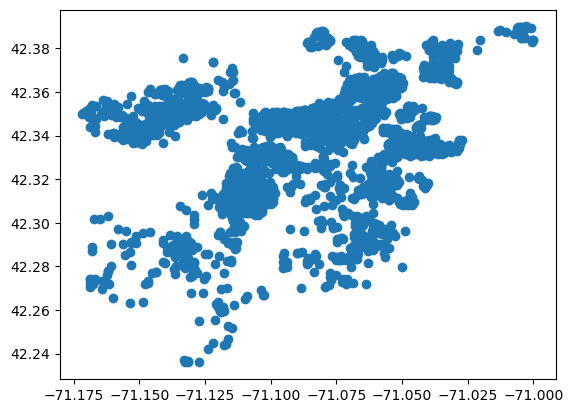

In [3]:
# this is where every Airbnb listing is in our data set (no map tho)
plt.scatter(listings['longitude'], listings['latitude'])

In [4]:
boston_geo = gpd.read_file("../inputs/Census2020_Tracts/Census2020_Tracts.shp")

In [5]:
# these coordinates are not standard
boston_geo['geometry'].head()

0    POLYGON ((757373.036 2913676.433, 757377.218 2...
1    POLYGON ((756308.459 2916770.814, 756446.058 2...
2    POLYGON ((757682.058 2924622.055, 757807.152 2...
3    POLYGON ((753408.502 2925331.042, 753418.584 2...
4    POLYGON ((759003.960 2926858.165, 759043.379 2...
Name: geometry, dtype: geometry

In [6]:
# set to the standard longitute/latitude system
boston = boston_geo.to_crs('epsg:4326')

In [7]:
# much better
boston['geometry'].head()

0    POLYGON ((-71.12623 42.24267, -71.12621 42.244...
1    POLYGON ((-71.13012 42.25117, -71.12960 42.251...
2    POLYGON ((-71.12491 42.27270, -71.12445 42.273...
3    POLYGON ((-71.14069 42.27470, -71.14065 42.275...
4    POLYGON ((-71.11999 42.27882, -71.11984 42.279...
Name: geometry, dtype: geometry

<Axes: >

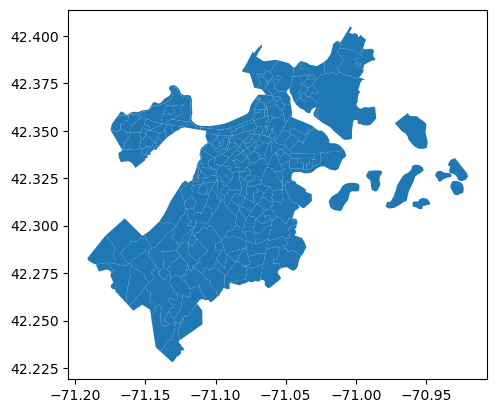

In [8]:
# census map
boston.plot()

In [9]:
# this step maps each longitude and latitude to a shapely point
listings = gpd.GeoDataFrame(listings, geometry=listings.apply(
        lambda srs: shapely.geometry.Point(srs['longitude'], srs['latitude']), axis='columns'
    ))

In [10]:
# function to create a new column based on whether or not a listing is in a tract
def assign_census_tract(bnb):
    bools = [geom.contains(bnb['geometry']) for geom in boston['geometry']]
    if True in bools:
        return boston.iloc[bools.index(True)]['NAME20']
    else:
        return np.nan

In [11]:
# .apply the function to the listings
listings['census_tract'] = listings.apply(assign_census_tract, axis='columns')

In [12]:
# this is how many listings are in each census tract
listings['census_tract'].value_counts().head()

102.05    88
201.01    86
1204      82
107.01    74
106       74
Name: census_tract, dtype: int64

In [13]:
# use .map() to apply value_counts to each value of 'NAME20'
boston['BNBs'] = boston['NAME20'].map(listings['census_tract'].value_counts())

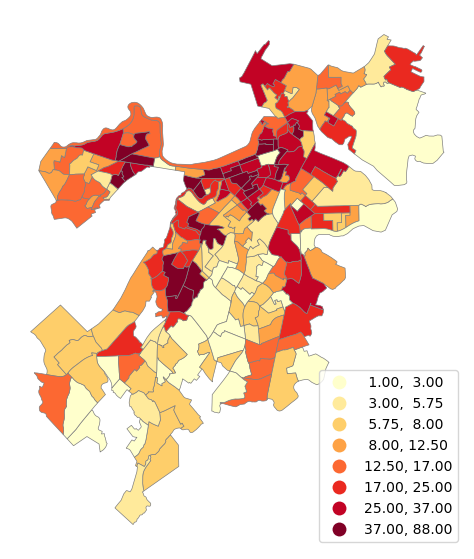

In [19]:
# what a nice choropleth map
# it shows the amount of listings in each zone
# but its not scaled for population density
f = plt.figure(figsize=(9, 7))
ax = f.gca()
kw = dict(column='BNBs', k=8, cmap='YlOrRd', edgecolor='gray', linewidth=0.5)
boston.plot(scheme='QUANTILES', ax=ax, **kw, legend=True, legend_kwds={'loc': 'lower right'})
ax.set_axis_off()

In [15]:
# this code reprojects the areas into an "equal-area" projection
# this is so that I can get listings per Kilometer^2
boston['BNBDensity'] = (boston['BNBs'] / boston['geometry']\
                            .to_crs('epsg:3395')\
                            .map(lambda p: p.area / 10**6))\
                            .fillna(0)

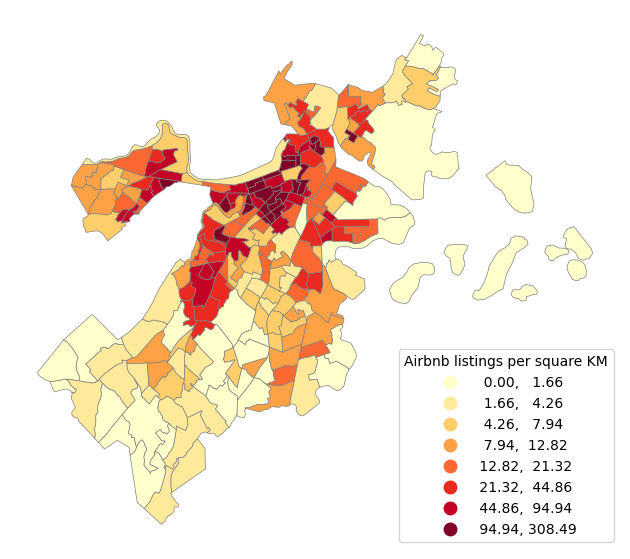

In [20]:
# this graph represents listings per square KM as zones
f = plt.figure(figsize=(9, 7))
ax = f.gca()
kw = dict(column='BNBDensity', k=8, cmap='YlOrRd', edgecolor='gray', linewidth=0.5)
boston.plot(scheme='QUANTILES', ax=ax, **kw, legend=True, legend_kwds={'loc': 'lower right', 'title': "Airbnb listings per square KM"})
ax.set_axis_off()